# Generalized Mie Near Field Plots

Chad Heaps
February 25, 2017

This was originally a separate utility, but is being added to mstm-scan to aid anyone running the calculations.  The saved scattered coefficient file should be the correct format to be read into the notebook.

This jupyter notebook plots the scattered near field from a Generalized Mie calculation.  The vector components are calculated using Fortran code from Daniel Mackowski's MSTM code (http://www.eng.auburn.edu/~dmckwski/scatcodes/).  The Fortran code is compiled using fortranmagic.  You could easily compile it with f2py separately, too.  There is a Fortran module func_nf and a python class NearField that take care of most of the computation.  They are mostly stitched together from other scripts/codes.

Only Fields in the Cartesian planes are currently supported.  

The code requires a text file with vector spherical harmonic coefficients and some header information.  Right now it will only calculate fields external to the particles.

The field for each particle is calculated individually and summed at the end.  The field is  expressed as

\begin{equation}
{\bf E}_\text{cart} = \sum_{l=1}^N \sum_{m=-n}^n a_{lm} {\bf N}_{lm}(r,\theta,\phi) + b_{lm} {\bf M}_{lm}(r,\theta,\phi)
\end{equation}

where the explicit forms for ${\bf N}_{lm}$ and ${\bf M}_{lm}$ may be found in the MSTM manual or other Mie theory resources.

In [1]:
import time
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try: 
    %load_ext fortranmagic
except:
    %install_ext https://raw.github.com/mgaitan/fortran_magic/master/fortranmagic.py
    %load_ext fortranmagic

In [3]:
%%fortran -v
module func_nf
    implicit none
    contains
    subroutine calcconstants (nbc, fnr, bcof) 
        integer, intent(in) :: nbc
        real*8, intent(inout), dimension(0:2*nbc) :: fnr
        real*8, intent(inout), dimension(0:nbc, 0:nbc) :: bcof
        
        integer l, n
        do n=1,2*nbc
            fnr(n)=dsqrt(dble(n))
        enddo
        bcof(0,0)=1.d0
        do n=0,nbc-1
            do l=n+1,nbc
                bcof(n,l)=fnr(n+l)*bcof(n,l-1)/fnr(l)
                bcof(l,n)=bcof(n,l)
            enddo
            bcof(n+1,n+1)=fnr(n+n+2)*fnr(n+n+1)*bcof(n,n)/fnr(n+1)/fnr(n+1)
        enddo
    end subroutine calcconstants

!
!  tau are the vector spherical harmonic functions, normalized
!
!
!  last revised: 15 January 2011

    subroutine taufunc(cb, phip,nmax,pvec)
         implicit none 
         integer, intent(in) :: nmax
         real(8), intent(in) :: cb, phip
         complex(8),intent(out) :: pvec(nmax*(nmax+2),2)
         
         real(8) :: drot(-1:1,0:nmax*(nmax+2)),tau(0:nmax+1,nmax,2),fnm
         integer :: n,m,nn1,mn
         complex(8) :: ci

         ci = dcmplx(0.0, 1.0)

         call rotcoef(cb,1,nmax,drot)

         do n=1,nmax
            nn1=n*(n+1)
            fnm=sqrt(dble(n+n+1)/2.d0)/4.d0
            do m=-n,-1
               mn=nn1+m
               tau(n+1,-m,1)=-fnm*(-drot(-1,mn)+drot(1,mn))
               tau(n+1,-m,2)=-fnm*(drot(-1,mn)+drot(1,mn))
            enddo
            do m=0,n
               mn=nn1+m
               tau(m,n,1)=-fnm*(-drot(-1,mn)+drot(1,mn))
               tau(m,n,2)=-fnm*(drot(-1,mn)+drot(1,mn))
            enddo
         enddo
         !!Reshaping to py preferred indexing
         do n=1,nmax
            nn1=n*(n+1)
               do m=-n,-1
                  mn=nn1+m
                  pvec(mn,1) = 2.0*tau(n+1,-m,1)*exp(ci*m*phip)
                  pvec(mn,2) = 2.0*tau(n+1,-m,2)*exp(ci*m*phip)
               enddo
               do m=0,n
                  mn=nn1+m
                  pvec(mn,1) = 2.0*tau(m,n,1)*exp(ci*m*phip)
                  pvec(mn,2) = 2.0*tau(m,n,2)*exp(ci*m*phip)
               enddo
         enddo
         
    end subroutine taufunc

    subroutine evalf(cthp, rdpw, phip, norder, ibess, nmn)
        complex*16, intent(out), dimension(2, norder*(norder+2),3) :: nmn
        complex*16, intent(in) :: rdpw
        real*8, intent(in) :: cthp, phip
        integer, intent(in) :: norder, ibess

        integer n, mn, nn1,m
        real*8 fnm
        !integer nbc
        !real*8, dimension(0:2*(2*(2*norder)+4)) :: fnr
        !real*8, dimension(0:2*(2*norder)+4, 0:2*(2*norder)+4) :: bcof
        real(8) :: legen(0:0,0:norder*(norder+2))

        complex*16 rhfp
        complex*16 ci
        complex*16 rhf(0:norder)
        complex(8) :: tau(norder*(norder+2),2)

        ci = dcmplx(0.0,1.0d0)
        
        !nbc = 2*(2*norder)+4 
        !call calcconstants (nbc, fnr, bcof) 

        call taufunc(cthp, phip, norder, tau)

        if(ibess.eq.1) then
           call cricbessel(norder, rdpw, rhf)
        elseif(ibess.eq.3) then
           call crichankel(norder, rdpw, rhf)
        endif 
        !Ricatti-Bessel (Hankel) function, so divide by kr
        rhf(:) = rhf(:)/rdpw
        
        !!For legendre function for nmn(1,1,:)
        call rotcoef(cthp,0,norder,legen)

        !Evaluate VSH components
        do n=1,norder
           rhfp=rhf(n-1)-n*rhf(n)/rdpw
           nn1=n*(n+1)
           !Normalization that is only used for the N_r component
           fnm = sqrt(dble((2*n+1))/(2.0*(n*(n+1))))
           do m=-n,n
              mn=nn1+m
              !CWH 04-05-2017
              !These are the correct VSH terms
              !!N(r,theta,phi)
              nmn(1, mn, 1) = fnm*(n*(n+1))*(rhf(n)/rdpw)*legen(0,mn)*exp(ci*m*phip)
              nmn(1, mn, 2) = rhfp*tau(mn,1)
              nmn(1, mn, 3) = ci*rhfp*tau(mn,2)
               
              !M(r,theta,phi)
              nmn(2, mn, 1)= cmplx(0.0,0.0)
              nmn(2, mn, 2)= ci*rhf(n)*tau(mn,2)
              nmn(2, mn, 3)= -rhf(n)*tau(mn,1)

           enddo
        enddo 
        nmn = nmn*sqrt(2.0)
    end subroutine evalf
    
    
    subroutine loop_points(norder, ibess, tM, tE, &
                           pt, pkr, pp, pEsphere, npoints,ndim)
    
    
        integer, intent(in) :: ndim, npoints, norder
        integer, dimension(npoints), intent(in) :: ibess
        real*8, intent(in), dimension(npoints) :: pt
        complex*16, intent(in), dimension(npoints) :: pkr
        real*8, intent(in), dimension(npoints) :: pp
        complex*16, intent(in), dimension(ndim) :: tM
        complex*16, intent(in), dimension(ndim) :: tE
        complex*16, intent(out), dimension(ndim, npoints, 3) :: pEsphere
        
        integer :: i, j, k
        complex*16 :: nmn3(2, ndim, 3)
                
        pEsphere(:,:,:) = dcmplx(0.0, 0.0)
        do i=1,npoints
            nmn3(:,:,:) = 0.0
            if(ibess(i).eq.0) then
                nmn3(:,:,:) = 0.0
            else
                call evalf(cos(pt(i)), pkr(i), pp(i), norder, ibess(i), nmn3)
            endif
            !subroutine evalf(cthp, rdpw, phip, norder, ibess, nmn)

            do j=1,ndim
                do k=1,3
                    pEsphere(j, i, k) = tM(j) * nmn3(1, j, k) + & 
                                        tE(j) * nmn3(2, j, k)
                enddo
            enddo
        enddo
 

    end subroutine loop_points
    
    
    
    subroutine rotcoef(cbe,kmax,nmax,dc)
         implicit none
         
         integer :: kmax,nmax,k,m,in,n,knmax,nn1,kn,im,m1, nbc
         real(8) :: cbe,sbe,dc(-kmax:kmax,0:nmax*(nmax+2)),cbe2,sbe2,dk0(-nmax-1:nmax+1),&
                    dk01(-nmax-1:nmax+1),sben,dkt,fmn,dkm0,dkm1,dkn1
        real*8, dimension(0:2*(2*(2*nmax)+4)) :: fnr
        real*8, dimension(0:2*(2*nmax)+4, 0:2*(2*nmax)+4) :: bcof

        nbc = 2*(2*nmax)+4 


        call calcconstants (nbc, fnr, bcof) 


         sbe=dsqrt((1.d0+cbe)*(1.d0-cbe))
         cbe2=.5d0*(1.d0+cbe)
         sbe2=.5d0*(1.d0-cbe)
         in=1
         dk0(0)=1.d0
         sben=1.d0
         dc(0,0)=1.d0
         dk01(0)=0.d0
         do n=1,nmax
            knmax=min(n,kmax)
            nn1=n*(n+1)
            in=-in
            sben=sben*sbe/2.d0
            dk0(n)=in*sben*bcof(n,n)
            dk0(-n)=in*dk0(n)
            dk01(n)=0.d0
            dk01(-n)=0.d0
            dc(0,nn1+n)=dk0(n)
            dc(0,nn1-n)=dk0(-n)
            do k=-n+1,n-1
               kn=nn1+k
               dkt=dk01(k)
               dk01(k)=dk0(k)
               dk0(k)=(cbe*dble(n+n-1)*dk01(k)-fnr(n-k-1)*fnr(n+k-1)*dkt)&
                     /(fnr(n+k)*fnr(n-k))
               dc(0,kn)=dk0(k)
            enddo
            im=1
            do m=1,knmax
               im=-im
               fmn=1.d0/fnr(n-m+1)/fnr(n+m)
               m1=m-1
               dkm0=0.d0
               do k=-n,n
                  kn=nn1+k
                  dkm1=dkm0
                  dkm0=dc(m1,kn)
                  if(k.eq.n) then
                     dkn1=0.d0
                  else
                     dkn1=dc(m1,kn+1)
                  endif
                  dc(m,kn)=(fnr(n+k)*fnr(n-k+1)*cbe2*dkm1 &
                          -fnr(n-k)*fnr(n+k+1)*sbe2*dkn1  &
                          -dble(k)*sbe*dc(m1,kn))*fmn
                  dc(-m,nn1-k)=dc(m,kn)*(-1)**(k)*im
               enddo
            enddo
         enddo
         end subroutine rotcoef


    real(8) function envj(n,x)
        implicit none
        integer :: n
        real(8) :: x
        n=max(1,abs(n))
        envj=0.5d0*dlog10(6.28d0*n)-n*dlog10(1.36d0*x/n)
    end function envj
!
!     ===================================================
!     Purpose: Determine the starting point for backward
!              recurrence such that the magnitude of
!              Jn(x) at that point is about 10^(-MP)
!     Input :  x     --- Argument of Jn(x)
!              MP    --- Value of magnitude
!     Output:  MSTA1 --- Starting point
!     ===================================================
!
!
!  last revised: 15 January 2011
!
         integer function msta1(x,mp)
         implicit none
         integer :: mp,n0,n1,it,nn
         real(8) :: x, a0,f1,f,f0
         a0=dabs(x)
         n0=int(1.1*a0)+1
         f0=envj(n0,a0)-mp
         n1=n0+5
         f1=envj(n1,a0)-mp
         do it=1,20
            nn=n1-(n1-n0)/(1.0d0-f0/f1)
            f=envj(nn,a0)-mp
            if(abs(nn-n1).lt.1) exit
            n0=n1
            f0=f1
            n1=nn
            f1=f
         enddo
         msta1=nn
    end function msta1
!
!     ===================================================
!     Purpose: Determine the starting point for backward
!              recurrence such that all Jn(x) has MP
!              significant digits
!     Input :  x  --- Argument of Jn(x)
!              n  --- Order of Jn(x)
!              MP --- Significant digit
!     Output:  MSTA2 --- Starting point
!     ===================================================
!
!
!  last revised: 15 January 2011
!
         integer function msta2(x,n,mp)
         implicit none
         integer :: n,mp,n0,n1,it,nn
         real(8) :: x,a0,hmp,ejn,obj,f0,f1,f
         a0=dabs(x)
         hmp=0.5d0*dble(mp)
         ejn=envj(n,a0)
         if (ejn.le.hmp) then
            obj=mp
            n0=int(1.1*a0)
         else
            obj=hmp+ejn
            n0=n
         endif
         f0=envj(n0,a0)-obj
         n1=n0+5
         f1=envj(n1,a0)-obj
         do it=1,20
            nn=n1-(n1-n0)/(1.0d0-f0/f1)
            f=envj(nn,a0)-obj
            if (abs(nn-n1).lt.1) exit
            n0=n1
            f0=f1
            n1=nn
            f1=f
         enddo
         msta2=nn+10
        end function msta2
        
subroutine cspherebessel(n,z,csj,csy)
         integer :: n,nm,k,m
         real(8) :: a0
         complex(8) :: z,csj(0:n),csy(0:n),csa,csb,cs,cf0,cf1,cf
         a0=cdabs(z)
         nm=n
         if (a0.lt.1.0d-60) then
            csj=(0.d0,0.d0)
            csy=(-1.d300,0.d0)
            csy(0)=(1.d0,0.d0)
            return
         endif
         csj=(0.d0,0.d0)
         csj(0)=cdsin(z)/z
         csj(1)=(csj(0)-cdcos(z))/z
         if (n.ge.2) then
            csa=csj(0)
            csb=csj(1)
            m=msta1(a0,200)
            if (m.lt.n) then
               nm=m
            else
               m=msta2(a0,n,15)
            endif
            cf0=0.0d0
            cf1=1.0d0-100
            do k=m,0,-1
               cf=(2.0d0*k+3.0d0)*cf1/z-cf0
               if (k.le.nm) csj(k)=cf
               cf0=cf1
               cf1=cf
            enddo
            if (cdabs(csa).gt.cdabs(csb)) cs=csa/cf
            if (cdabs(csa).le.cdabs(csb)) cs=csb/cf0
            do k=0,min(nm,n)
               csj(k)=cs*csj(k)
            enddo
         endif
         csy=(1.d200,0.d0)
         csy(0)=-cdcos(z)/z
         csy(1)=(csy(0)-cdsin(z))/z
         do k=2,min(nm,n)
            if (cdabs(csj(k-1)).gt.cdabs(csj(k-2))) then
               csy(k)=(csj(k)*csy(k-1)-1.0d0/(z*z))/csj(k-1)
            else
               csy(k)=(csj(k)*csy(k-2)-(2.0d0*k-1.0d0)/z**3)/csj(k-2)
            endif
         enddo
         end subroutine cspherebessel
            
subroutine crichankel(n,ds,xi)
         implicit none
         integer :: n,i
         complex(8) :: ds,psi(0:n),chi(0:n),xi(0:n),ci,&
                       psi0
         ci = dcmplx(0.0,1.0d0)
         xi(0)=-ci*cdexp(ci*ds)
         psi0=cdsin(ds)
         if(cdabs(xi(0))/cdabs(psi0).lt.1.d-6) then
            xi(1)=-cdexp(ci*ds)*(ci+ds)/ds
            do i=2,n
               xi(i)=dble(i+i+1)/ds*xi(i-1)-xi(i-2)
            enddo
         else
            call cspherebessel(n,ds,psi,chi)
            do i=1,n
               xi(i)=(psi(i)+ci*chi(i))*ds
            enddo
         endif
end subroutine crichankel 
!
!  ricatti-bessel function psi(n), complex argument
!
!
!  last revised: 15 January 2011
!
         subroutine cricbessel(n,ds,psi)
         implicit none
         integer :: n,i
         complex(8) :: ds,psi(0:n),chi(0:n)
         call cspherebessel(n,ds,psi,chi)
         do i=0,n
            psi(i)=psi(i)*ds
         enddo
         return
end subroutine cricbessel
            
         subroutine ricbessel(n,ds,eps,nmax,psi)
         implicit none
         integer :: n,nmax,ns,i
         real(8) :: ds,dns,sn,psi(0:n),psit,ds2,sum,eps,err
         if(int(ds).lt.n) then
            ns=nint(ds+4.*(ds**.3333d0)+17)
            ns=max(n+10,ns)
            dns=0.d0
            do i=ns-1,n,-1
               sn=dble(i+1)/ds
               dns=sn-1.d0/(dns+sn)
            enddo
            psi(n)=dns
            psi(n-1)=dble(n)/ds-1.d0/(dns+dble(n)/ds)
            do i=n-2,1,-1
               sn=dble(i+1)/ds
               psi(i)=sn-1.d0/(psi(i+1)+sn)
            enddo
            psit=dsin(ds)
            psi(0)=psit
            ds2=ds*ds
            sum=psit*psit/ds2
            do i=1,n
               psit=psit/(dble(i)/ds+psi(i))
               sum=sum+dble(i+i+1)*psit*psit/ds2
               err=dabs(1.d0-sum)
               psi(i)=psit
               if(err.lt.eps) then
                  nmax=i
                  return
               endif
            enddo
            nmax=n
         else
            psi(0)=dsin(ds)
            psi(1)=psi(0)/ds-dcos(ds)
            do i=1,n-1
               sn=dble(i+i+1)/ds
               psi(i+1)=sn*psi(i)-psi(i-1)
            enddo
            nmax=n
         endif
         end subroutine ricbessel

            
            
end module func_nf



Ok. The following fortran objects are ready to use: func_nf


In [4]:
# print("{}".format(func_nf.__doc__))

In [46]:


############################################################
#                        Chad Heaps                        #
#                        03-10-2017                        #
#                                                          #
#       Program to evaluate the near-field                 # 
#       electric field for the particle-centered           #
#       VSH expansion from Mackowski's code SCSMFO         #
#                                                          #
#                                                          #
#                                                          #      
#                                                          #
############################################################

class Cluster(object):
    def __init__(self):
        self.npart = 1
        #self.maxorder = 1
        #self.wavelen =  0.532
        #self.refmed  = 0.532
        #self.coef = np.zeros([npart, maxorder*(maxorder+2), 2], dtype=np.complex)
        #self.norder = np.zeros([npart], dtype=np.int)
        #self.coord = np.zeros([npart,4])



class NearField(object):
    def __init__(self):
        self.coef_filename = 'pan.dat'
        self.output_file = 'test.out'
        #size of the grid
        self.nx = 25
        self.ny = 25
        self.nz = 1
        self.xlim = np.array([-50, 50])
        self.ylim = np.array([-50, 50])
        self.zlim = np.array([0, 0])
        self.plane = 'xy'
        self.save_int = 1
        self.iprint = 0

    def run(self):
        """
        Perform all of the necessary steps for the calculation
        """

        cluster = self.read_coef_file(self.coef_filename)
        
        #Convert to microns
        #cluster.coord/=1000.0 
        #cluster.wavelen/=1000.0
        #Scalar wave number for medium
        self.wavenum_med  = (2.*np.pi*cluster.refmed)/cluster.wavelen 
        if self.iprint > 0:
            with open(self.output, 'w') as outfile:
                outfile.write('Number of '
                              'particles: {}\n'.format(cluster.npart))
                outfile.write('Wavelength:'
                              '{}\n'.format(1000.*cluster.wavelen))
                outfile.write('Maximum order of multipole expansions:'
                              '{}\n'.format(cluster.maxorder))


        #Grid for the image
        if self.plane == 'xy':
            npoints = self.nx*self.ny
            xx, yy = np.meshgrid(np.linspace(self.xlim[0], 
                                             self.xlim[1], 
                                             self.nx), 
                                 np.linspace(self.ylim[0], 
                                             self.ylim[1], 
                                             self.ny))
            grid_x = xx.reshape(npoints)
            grid_y = yy.reshape(npoints)
            grid_z = np.zeros([npoints])
            grid_z.fill(self.zlim[0])
#             Take inputs in nm and convert to micron
            grid_x/=1000.
            grid_y/=1000.
            grid_z/=1000. 
            plane_grid = np.vstack((grid_x, grid_y))

        if self.plane == 'xz':
            npoints = self.nx*self.nz
            xx, zz = np.meshgrid(np.linspace(self.xlim[0], 
                                             self.xlim[1], 
                                             self.nx), 
                                 np.linspace(self.zlim[0], 
                                             self.zlim[1], 
                                             self.nz))
            grid_x = xx.reshape(npoints)
            grid_z = zz.reshape(npoints)
            grid_y = np.zeros([npoints])
            grid_y.fill(self.ylim[0])
            #Take inputs in nm and convert to micron
            grid_x/=1000.
            grid_y/=1000.
            grid_z/=1000. 
            plane_grid = np.vstack((grid_x, grid_z))

        if self.plane == 'yz':
            npoints = self.ny*self.nz
            yy, zz = np.meshgrid(np.linspace(self.ylim[0], 
                                             self.ylim[1], 
                                             self.ny), 
                                 np.linspace(self.zlim[0], 
                                             self.zlim[1], 
                                             self.nz))
            grid_y = yy.reshape(npoints)
            grid_z = zz.reshape(npoints)
            grid_x = np.zeros([npoints])
            grid_x.fill(self.xlim[0])
            #Take inputs in nm and convert to micron
            grid_x/=1000.
            grid_y/=1000.
            grid_z/=1000.
            plane_grid = np.vstack((grid_y, grid_z))
        

        if self.iprint > 0:
            with open(self.output, 'w') as outfile:
                outfile.write("Number of points in the image: {}\n".format(npoints))
        #'part' prefix indicates array with coordinates for all particles
        part_x = grid_x[:, None] - cluster.coord[:,1]
        part_y = grid_y[:, None] - cluster.coord[:,2]
        part_z = grid_z[:, None] - cluster.coord[:,3]
        
        part_r = np.sqrt(part_x**2 + part_y**2 + part_z**2)
        #offset from zero slightly
        part_r[np.where(part_r==0)] = 1e-10
         
        #Calc spherical coordinates
        #Normalized to r for correct angles
        part_phi =  np.angle((part_x/part_r)+1.0j*(part_y/part_r))
        part_theta = np.arccos(part_z/part_r)
      
        #Determine which bessel function to use
        rless  = part_r < cluster.coord[:,0]
        rgreat = part_r > cluster.coord[:,0]
        rlany = (1 - np.sum(rless,axis = -1))
        
        #the integer 1 and 3 correspond to ibess values
        ibess = 0*rless + rlany[:,None]*3*rgreat
        #ibess = self.intfield*1*rless + rlany[:,None]*self.extfield*3*rgreat
        part_kr = 0.0*part_r*rless + self.wavenum_med*part_r*rgreat
        
        if self.iprint > 0:
            with open(self.output, 'w') as outfile:
                outfile.write('wavenum_med {}\n'.format(self.wavenum_med))

        maxdim = cluster.maxorder*(cluster.maxorder+2)
        #Separated into TM and TE parts
        empEspher = np.zeros([cluster.npart, 2, maxdim, npoints, 3], dtype=np.complex)
        #Multiplied by coefficients removing one index
        pEdat = np.zeros([cluster.npart, maxdim, npoints, 3], dtype=np.complex)
        self.pEspher = np.zeros([cluster.npart, npoints, 3], dtype=np.complex)
        self.pEcart  = np.zeros([cluster.npart, npoints, 3], dtype=np.complex)
        t_startf = time.time() 
        for ipart in range(cluster.npart):
            #Calculate field for each particle center in spherical coordinates
            pkr =  part_kr[:,ipart]
            pt =  part_theta[:,ipart]
            pp =  part_phi[:,ipart]
            nmax = cluster.norder[ipart]
            ndim = nmax*(nmax+2)
            tM = cluster.coef[ipart, :ndim, 0]
            tE = cluster.coef[ipart, :ndim, 1]
            pEdat[ipart, :ndim, :, :] = func_nf.loop_points(nmax, ibess[:,ipart],
                                                              tM, tE, pt, pkr,
                                                              pp)
            #print(pEdat)
            self.pEspher[ipart, :, :] = pEdat[ipart,:,:,:].sum(axis=0)
            self.pEcart[ipart, :, :] = self.vec_spher_to_cart(self.pEspher[ipart, :, :], pt, pp)
            if self.iprint > 0:
                with open(self.output, 'w') as outfile:
                    outfile.write('time to '
                    'evaluate functions {}\n'.format(time.time() - t_startf))
        
        Esphtot =  self.pEspher.sum(axis=0)  
        Ecarttot = self.pEcart.sum(axis=0)
        
        self.Ecartint = (np.abs(Ecarttot)**2).sum(axis=-1)
        self.Esphint = (np.abs(Esphtot)**2).sum(axis=-1)
        self.Ecarttot = Ecarttot
        self.grid_x = 1000.*grid_x
        self.grid_y = 1000.*grid_y
        self.grid_z = 1000.*grid_z
        if self.save_int:
            np.savetxt(self.name + '.int', np.vstack((plane_grid, self.Ecartint)).T) 
        if self.save_etot:
            np.savetxt(self.name + '.etot', np.vstack((plane_grid, 
                                           self.Ecarttot[:, 0].real, 
                                           self.Ecarttot[:, 0].imag, 
                                           self.Ecarttot[:, 1].real, 
                                           self.Ecarttot[:,1].imag, 
                                           self.Ecarttot[:, 2].real, 
                                           self.Ecarttot[:,2].imag)).T)

   
        return

    def vec_spher_to_cart(self, spv, theta, phi):
        """ 
        Takes spherical vector components spv and expresses them in cartesian components
        returns cartv
        """
        if len(spv.shape) == 1:
            spv = spv.reshape(-1,1)
        cartv = np.zeros(spv.shape, dtype=np.complex)
        st = np.sin(theta)
        ct = np.cos(theta)
        sph = np.sin(phi)
        cph = np.cos(phi)
        cartv[:,0] = ( spv[:,0] * st * cph 
                     + spv[:, 1] * ct * cph
                     - spv[:, 2] * sph )
        cartv[:,1] = ( spv[:,0] * st * sph 
                     + spv[:, 1] * ct * sph
                     + spv[:, 2] * cph ) 
        cartv[:,2] = ( spv[:,0] * ct
                     - spv[:, 1] * st )
        return cartv
    
    def read_coef_file(self, file):
        ##Extract information from coefficient file
        find_float = re.compile('-?[0-9]*\.?[0-9]+')
        find_int = re.compile('-?[0-9]+\s')
        find_sci = re.compile('-?[0-9]*\.[0-9]*E[+-]?[0-9]+')
        coef_file = open(file, 'r')
        coef_lines = coef_file.readlines()
        coef_file.close()

        cluster = Cluster() 

        prelim  = re.split('\s+', coef_lines[0].strip())
        cluster.npart = np.int(prelim[0])

        cluster.maxorder = np.int(prelim[1])    
        cluster.wavelen = np.float(prelim[2])
        cluster.refmed  = np.float(prelim[3]) + 1.0j*np.float(prelim[4])
        if cluster.refmed.imag != 0.0:
            print('Warning, a complex refractive index medium was used in '
                  'the scattering calculation.  This has not been tested '
                  'for the near field code!')
        
        cluster.coef = np.zeros([cluster.npart, cluster.maxorder*(cluster.maxorder+2), 2], dtype=np.complex)
        
        cluster.norder = np.zeros([cluster.npart], dtype=np.int)
        cluster.coord = np.zeros([cluster.npart,4])
        i_line = 1
        for i_part in range(cluster.npart):
            part_prelim = re.split('\s+', coef_lines[i_line].strip())
            cluster.norder[i_part] = np.int(part_prelim[0])
            cluster.coord[i_part,] = np.asarray(part_prelim[1:5])
            i_line+=1
            for i in range(cluster.norder[i_part]*(cluster.norder[i_part]+2)):
                tc = find_sci.findall(coef_lines[i_line])
                cluster.coef[i_part,i,0] = np.float(tc[0]) + 1.0j*np.float(tc[1])
                cluster.coef[i_part,i,1] = np.float(tc[2]) + 1.0j*np.float(tc[3])
                i_line+=1

        return cluster


# Heterodimer near-field scattering

Example 1 plots the near field for a dimer where one particle is silver and the other is gold.  The plot uses the scattered field at 360 nm.  The result is excitation at the silver nanoparticle but not the gold.

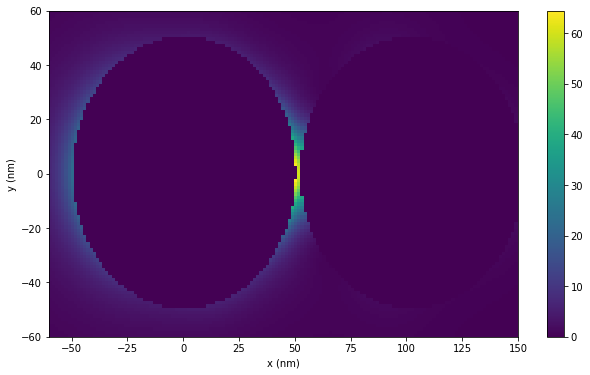

CPU times: user 312 ms, sys: 33.7 ms, total: 346 ms
Wall time: 347 ms


In [62]:
%%time
xy_dimer1 = NearField()
xy_dimer1.coef_filename = 'amn_test1_planewave.dat'
#xy_dimer1.coef_filename = 'amn_test4_dimer.dat'

xy_dimer1.name = 'dimer_ex1'
xy_dimer1.output = xy_dimer1.name + '.out'

xy_dimer1.plane = 'xy'
xy_dimer1.nx = 150
xy_dimer1.ny = 100
xy_dimer1.nz = 1
xy_dimer1.xlim = np.array([-60.0,150.0])
xy_dimer1.ylim = np.array([-60.0,60.0])
xy_dimer1.zlim = np.array([0.0, 0.0])


xy_dimer1.save_int  = 0
xy_dimer1.save_etot = 0

xy_dimer1.run()


aspect = (xy_dimer1.xlim[1] - xy_dimer1.xlim[0] )/ (xy_dimer1.ylim[1] - xy_dimer1.ylim[0])
size = 6.0
fig, ax = plt.subplots(1,1, figsize=(aspect*size, size));

x = xy_dimer1.grid_x.reshape(xy_dimer1.ny, xy_dimer1.nx)
y = xy_dimer1.grid_y.reshape(xy_dimer1.ny, xy_dimer1.nx)
z = xy_dimer1.Ecartint.reshape(xy_dimer1.ny, xy_dimer1.nx)

pcm = ax.pcolormesh(x, y, z)
#ax.axis('square')
plt.axis(np.r_[xy_dimer1.xlim, xy_dimer1.ylim])
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.colorbar(pcm)
plt.show()

# Dimer scattering

This is a simpler case of two particles of the same type scattering a plane wave.  In this case, two gold particles at 532 nm

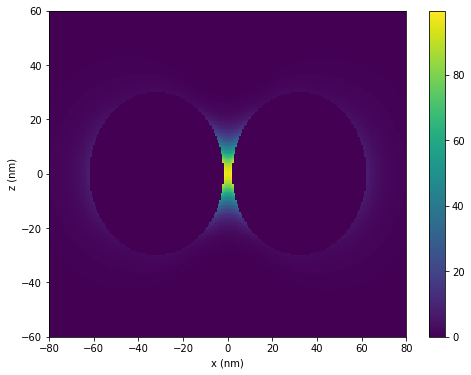

CPU times: user 898 ms, sys: 89.8 ms, total: 987 ms
Wall time: 994 ms


In [63]:
%%time
xy_dimer2 = NearField()
xy_dimer2.coef_filename = 'amn_test5_pw.dat'

xy_dimer2.name = 'dimer_ex2'
xy_dimer2.output = xy_dimer2.name + '.out'

xy_dimer2.plane = 'xy'
xy_dimer2.nx = 250
xy_dimer2.ny = 250
xy_dimer2.nz = 1
xy_dimer2.xlim = np.array([-80.0,80.0])
xy_dimer2.ylim = np.array([-60.0,60.0])
xy_dimer2.zlim = np.array([0.0, 0.0])


xy_dimer2.save_int  = 0
xy_dimer2.save_etot = 0

xy_dimer2.run()


aspect = (xy_dimer2.xlim[1] - xy_dimer2.xlim[0] )/ (xy_dimer2.ylim[1] - xy_dimer2.ylim[0])
size = 6.0
fig, ax = plt.subplots(1,1, figsize=(aspect*size, size));

x = xy_dimer2.grid_x.reshape(xy_dimer2.ny, xy_dimer2.nx)
y = xy_dimer2.grid_y.reshape(xy_dimer2.ny, xy_dimer2.nx)
z = xy_dimer2.Ecartint.reshape(xy_dimer2.ny, xy_dimer2.nx)

pcm = ax.pcolormesh(x, y, z)
#ax.axis('square')
#plt.axis(np.r_[xy_dimer2.xlim, xy_dimer2.ylim])
plt.xlabel('x (nm)')
plt.ylabel('z (nm)')
plt.colorbar(pcm)
plt.show()

## Scattered field from dipole emission

Even though the dipole emitter is not included, the field is still so intensely focused in the hot spot that the near field is entirely dominated by it.

Also, near-field calculations from dipole emission require much larger VSH expansions and therefore take much longer

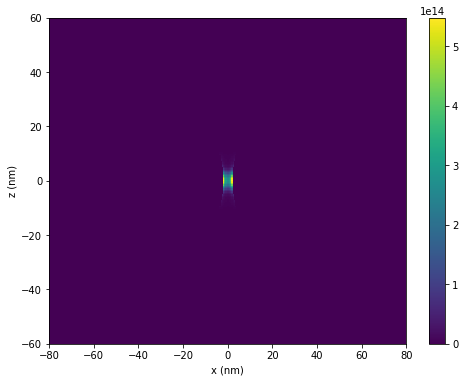

CPU times: user 15.6 s, sys: 3.3 s, total: 18.9 s
Wall time: 21 s


In [64]:
%%time
xy_dimer3 = NearField()
xy_dimer3.coef_filename = 'amn_test4_dimer.dat'

xy_dimer3.name = 'dimer_ex3'
xy_dimer3.output = xy_dimer3.name + '.out'

xy_dimer3.plane = 'xy'
xy_dimer3.nx = 300
xy_dimer3.ny = 225
xy_dimer3.nz = 1
xy_dimer3.xlim = np.array([-80.0,80.0])
xy_dimer3.ylim = np.array([-60.0,60.0])
xy_dimer3.zlim = np.array([0.0, 0.0])


xy_dimer3.save_int  = 0
xy_dimer3.save_etot = 0

xy_dimer3.run()


aspect = (xy_dimer3.xlim[1] - xy_dimer3.xlim[0] )/ (xy_dimer3.ylim[1] - xy_dimer3.ylim[0])
size = 6.0
fig, ax = plt.subplots(1,1, figsize=(aspect*size, size));

x = xy_dimer3.grid_x.reshape(xy_dimer3.ny, xy_dimer3.nx)
y = xy_dimer3.grid_y.reshape(xy_dimer3.ny, xy_dimer3.nx)
z = xy_dimer3.Ecartint.reshape(xy_dimer3.ny, xy_dimer3.nx)

pcm = ax.pcolormesh(x, y, z)
#ax.axis('square')
#plt.axis(np.r_[xy_dimer3.xlim, xy_dimer3.ylim])
plt.xlabel('x (nm)')
plt.ylabel('z (nm)')
plt.colorbar(pcm)
plt.show()

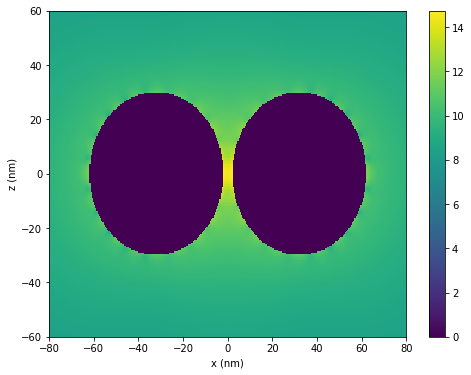

In [65]:
aspect = (xy_dimer3.xlim[1] - xy_dimer3.xlim[0] )/ (xy_dimer3.ylim[1] - xy_dimer3.ylim[0])
size = 6.0
fig, ax = plt.subplots(1,1, figsize=(aspect*size, size));

x = xy_dimer3.grid_x.reshape(xy_dimer3.ny, xy_dimer3.nx)
y = xy_dimer3.grid_y.reshape(xy_dimer3.ny, xy_dimer3.nx)
#z = xy_dimer3.Ecartint.reshape(xy_dimer3.ny, xy_dimer3.nx)
#Try log scale
z = np.array([np.log10(i) if i > 0.0 
                          else i 
                          for i in xy_dimer3.Ecartint]).reshape(xy_dimer3.ny, 
                                                                 xy_dimer3.nx)
pcm = ax.pcolormesh(x, y, z)
#ax.axis('square')
#plt.axis(np.r_[xy_dimer3.xlim, xy_dimer3.ylim])
plt.xlabel('x (nm)')
plt.ylabel('z (nm)')
plt.colorbar(pcm)
plt.show()